# EDA

## 0. Imports

### 0.1 Function Imports

In [1]:
# Function imports
from os import chdir
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
import pandas as pd
from IPython.display import display, Markdown
sns.set_style('whitegrid')

### 0.2 File Imports

In [2]:
# Move up two directories, to project base directory
chdir("../..")

In [3]:
# Import data
df_games = pd.read_parquet("data/store_info.parquet")
df_genres = pd.read_parquet("data/genres.parquet")
df_categories = pd.read_parquet("data/categories.parquet")

ddf_reviews = dd.read_parquet("data/reviews.parquet/")
ddf_reviews = ddf_reviews.rename(columns={"voted_up": "voted_up"})
ddf_reviews["language"] = ddf_reviews["language"].astype("category")
df_reviews = ddf_reviews.compute()
ddf_reviews = dd.from_pandas(df_reviews)

## 1. Basic EDA

### 1.1 Recommendation Distribution
Recommendations are not reviews, they are just "upvotes" for a game.

We can see that lower recommendation counts are more common.

The steam unofficial API does not report recommendation counts <= 100, so the left side of this graph is empty when it really shouldn't be.

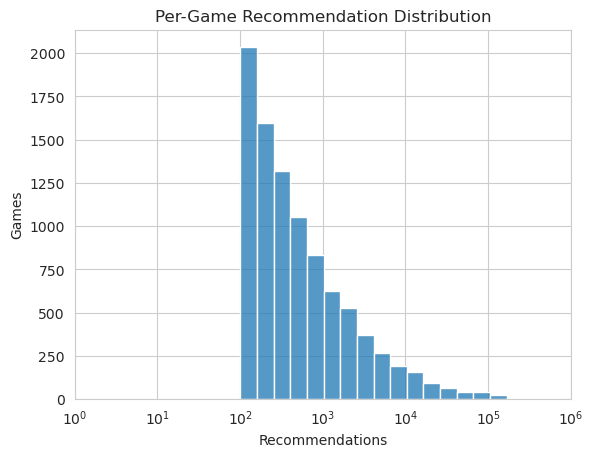

In [4]:
sns.histplot(df_games, x="recommendations", bins="doane", log_scale=(True, False))
plt.ylabel("Games")
plt.xlabel("Recommendations")
plt.xlim(1, 10**6)
plt.title("Per-Game Recommendation Distribution")
plt.show()

### 1.2 Review Distribution
Lower review counts are more common. This makes sense intuitively, and matches what we see for recommendations.

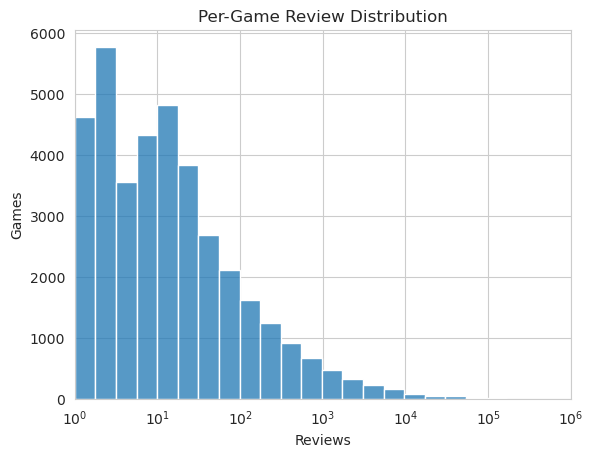

In [5]:
sns.histplot(
    df_reviews["steam_appid"].value_counts().reset_index(),
    x="count",
    bins="doane",
    log_scale=(True, False),
)
plt.ylabel("Games")
plt.xlabel("Reviews")
plt.xlim((1, 10**6))
plt.title("Per-Game Review Distribution")
plt.show()

### 1.3 Review Percent by Sentiment
Notably, the majority of reviews are positive. This will make it challenging to correctly classify negative reviews.

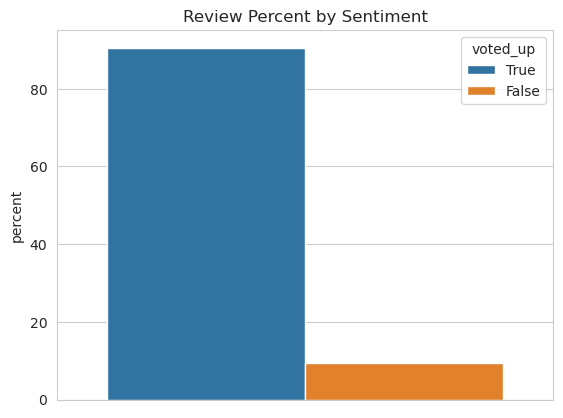

In [6]:
sns.countplot(
    df_reviews,

    x=np.zeros(len(df_reviews)),

    hue="voted_up",
    hue_order=[True, False],
    stat="percent",
)

plt.gca().xaxis.set_visible(False)

plt.title("Review Percent by Sentiment")
plt.show()

## 2. Intermediate EDA - Categorical Features

### 2.1 Review/Recommendation Co-distribution
The graph below illustrates that games with more recommendations tend to have more reviews.
The trend is mostly linear, but has pretty significant variation.

In [7]:
# Adds review count to games table
df_games = df_games.merge(
    pd.DataFrame(df_reviews["steam_appid"].value_counts()).rename(
        columns={"count": "review_count"}
    ),
    on="steam_appid",
)

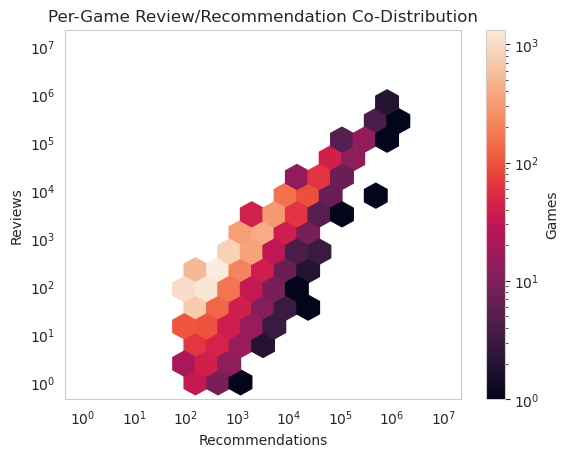

In [8]:
# Plots review/recommendation co-distribution
df_recommended_games = df_games[df_games["recommendations"] > 0]

plt.hexbin(
    x=df_recommended_games["recommendations"],
    y=df_recommended_games["review_count"],
    xscale="log",
    yscale="log",
    bins="log",
    gridsize=16,
    # cmap='Blues',
    extent=(0, 7, 0, 7),
)
plt.colorbar(label="Games")
plt.xlabel("Recommendations")
plt.ylabel("Reviews")
plt.title("Per-Game Review/Recommendation Co-Distribution")
plt.grid(False)
plt.show()

### 2.2 Game Genre Breakdown
The table below shows how many games present are in each genre. Genres are not mutually-exclusive and are often overlapping.

The table below illustrates which genres might be useful tags, at least on the basis of membership. It's probably safe to assume that over/under-represented categories aren't very useful.

That said... personally I find "action" and "adventure" to be pretty meaningless genres.

Also, *all* these games are supposed to be in the indie genre, so I'm not sure what went wrong there...

In [33]:
# Gets game counts per genre tag
df_genre_counts = (
    pd.DataFrame(df_genres.sum())
    .rename(columns={0: "Count"})
    .sort_values("Count", ascending=False)
)

# Converts game counts to percentages (of all games)
df_genre_counts["Percent"] = df_genre_counts["Count"] / len(df_genres) * 100

# Generates gmap for table coloring
# Having a hard time visualizing quantitative differences across orders of magnitude?
#   Ask you doctor about logarithmic scales today.
df_genre_counts_gmap = np.log10(df_genre_counts)

# Normalizes percent color scale to enforce clipping below .01% and caompatibility with count color scale
df_genre_counts_gmap["Percent"] = df_genre_counts_gmap["Percent"] / 2

# Normalizes logarithmic game count scale to go from 1 to -1 for compatibility with percent color scale
df_genre_counts_gmap["Count"] = (
    2
    * (df_genre_counts_gmap["Count"] - df_genre_counts_gmap["Count"].min())
    / (np.log10(len(df_genres)) - df_genre_counts_gmap["Count"].min())
    - 1
)

# vmax set to whatever value corresponds to the total number of games (or 100%)
# vmin set to a reasonable number to induce clipping 
#   For count: smallest number of games per genre, probably 1
#   For percent: 0.01%

df_genre_counts.style.background_gradient(
    cmap="viridis", gmap=df_genre_counts_gmap, axis=None, vmax=1, vmin=-1
).format(precision=2)

,Count,Percent
Indie,55794,95.43
Casual,25836,44.19
Action,24907,42.60
Adventure,23270,39.80
Simulation,10690,18.28
Strategy,10580,18.10
RPG,9901,16.93
Early Access,5767,9.86
Free To Play,4684,8.01
Sports,2222,3.80


### 2.3 Game Genre Co-groupings
Graph illustrates what portion of games in the "current" genre are in the "query" genre. Only for genres with >= 100 games.

Not especially informative (violent games are also gorey).

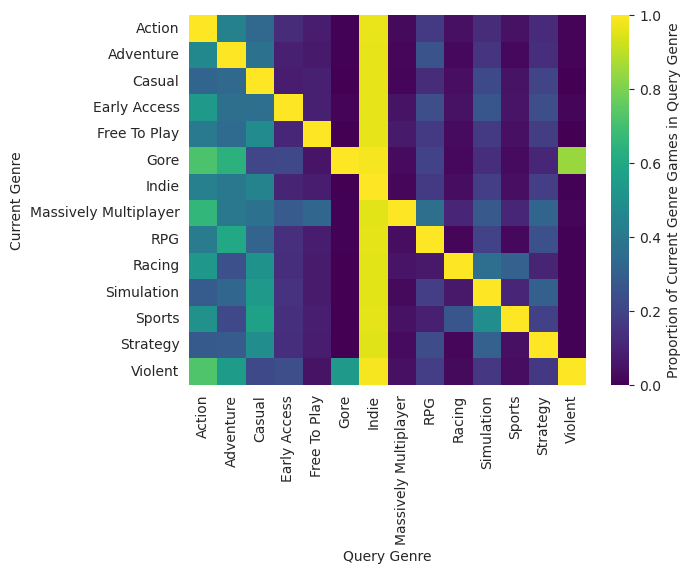

In [10]:
df_genre_average = pd.DataFrame()
rows_to_drop = []
for genre in df_genres.columns:
    if df_genres[genre].sum() >= 100:
        df_genre_average[genre] = df_genres[df_genres[genre] == True].mean()
    else:
        rows_to_drop.append(genre)

for row in rows_to_drop:
    df_genre_average = df_genre_average.drop(row)

# df_genre_average = df_genre_average.drop('genres: Indie', axis=0)
# df_genre_average = df_genre_average.drop('genres: Indie', axis=1)

df_genre_average = df_genre_average.transpose()

sns.heatmap(
    df_genre_average,
    vmin=0,
    vmax=1,
    cmap="viridis",
    cbar_kws={"label": "Proportion of Current Genre Games in Query Genre"},
)
plt.xlabel("Query Genre")
plt.ylabel("Current Genre")
plt.show()

### 2.3 Game Compatibility Breakdown
Some of these are probably worth keeping track of. If not for clustering, for recommending specific kinds of games (multi-player, local co-op, etc.)

No co-groupings this time since I don't think they'd be meaningful.

In [26]:
len(df_categories)

58465

In [32]:
# Same as above but for hardware/software compatibility
df_category_counts = (
    pd.DataFrame(df_categories.sum())
    .rename(columns={0: "Count"})
    .sort_values("Count", ascending=False)
)
df_category_counts["Percent"] = df_category_counts["Count"] / len(df_categories) * 100
df_category_counts_gmap = np.log10(df_category_counts)

df_category_counts_gmap["Percent"] = df_category_counts_gmap["Percent"] / 2
df_category_counts_gmap["Count"] = (
    2
    * (df_category_counts_gmap["Count"] - df_category_counts_gmap["Count"].min())
    / (np.log10(len(df_genres)) - df_category_counts_gmap["Count"].min())
    - 1
)
df_category_counts.style.background_gradient(
    cmap="viridis", gmap=df_category_counts_gmap, axis=None, vmax=1, vmin=-1
).format(
    precision=2,
)

,Count,Percent
Single-player,56243,96.20
Family Sharing,44764,76.57
Steam Achievements,28944,49.51
Steam Cloud,14172,24.24
Full controller support,13821,23.64
Multi-player,9377,16.04
Partial Controller Support,7646,13.08
Steam Trading Cards,7008,11.99
PvP,6028,10.31
Steam Leaderboards,5317,9.09


## 3 Intermediate Reviews - Quantitative Features

### 3.1 Reviews per Author
The number of reviews per author appeals to follow an exponential distribution. That's pretty cool... but I'm not sure whether it has any practical implications.

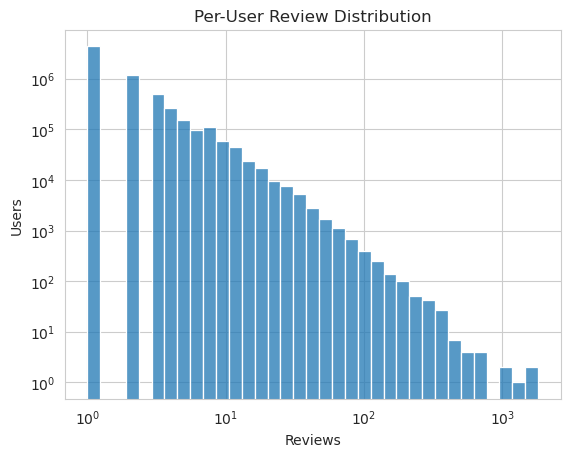

In [12]:
# Calculates/plots reviews-per-author
df_reviews_per_author = pd.DataFrame(
    ddf_reviews["author_steamid"].value_counts().compute()
)

sns.histplot(df_reviews_per_author, x="count", bins="doane", log_scale=(True, False))
plt.yscale("log")
plt.ylabel("Users")
plt.xlabel("Reviews")
plt.title("Per-User Review Distribution")
plt.show()

### 3.2 Author playtime at review
It does look like negative reviews tend to be associated with lower playtimes, but the duration of a game varies so much, it's likely not useful to consider the metric in this state.

(Play times are in hours)

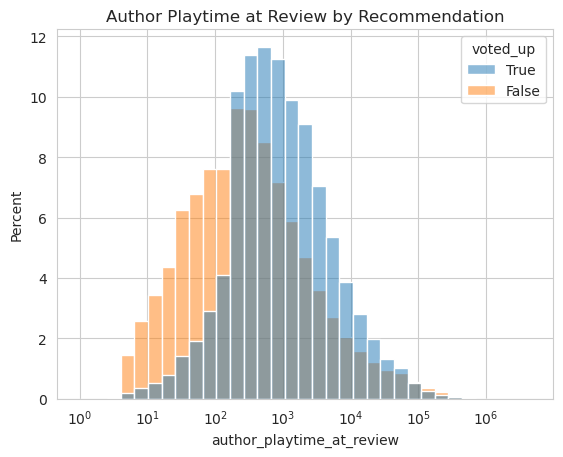

In [13]:
sns.histplot(
    df_reviews,
    x="author_playtime_at_review",
    hue="voted_up",
    bins="doane",
    stat="percent",
    hue_order=[True, False],
    common_norm=False,
    log_scale=(True, False),
)

plt.title("Author Playtime at Review by Recommendation")

plt.show()

### 3.3 Absolute Playtime Since Review
We can see that users tend to spend more time in games post-review if the review was positive, but there's more overlap than I'd like to see. 

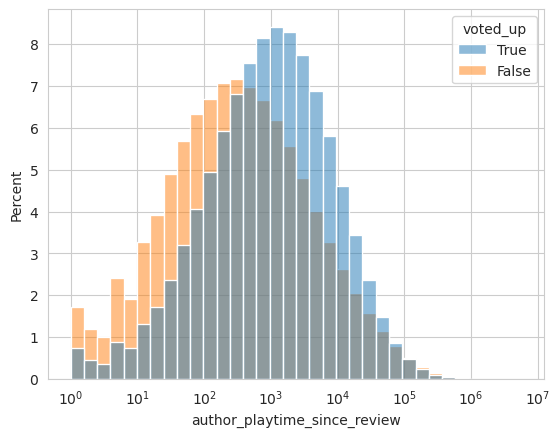

In [14]:
df_reviews["author_playtime_since_review"] = (
    df_reviews["author_playtime_forever"] - df_reviews["author_playtime_at_review"]
)

sns.histplot(
    df_reviews,
    x="author_playtime_since_review",
    hue="voted_up",
    bins="doane",
    stat="percent",
    hue_order=[True, False],
    common_norm=False,
    log_scale=(True, False),
)

plt.show()

### 3.4 Relative Playtime since Review
Another attempt to extract meaning from playtime: the ratio of a user's lifetime playtime to their playtime at review, minus one.
Probably relates better to whether a review is positive or negative, but may not indicate anything about how much the user enjoys the game.

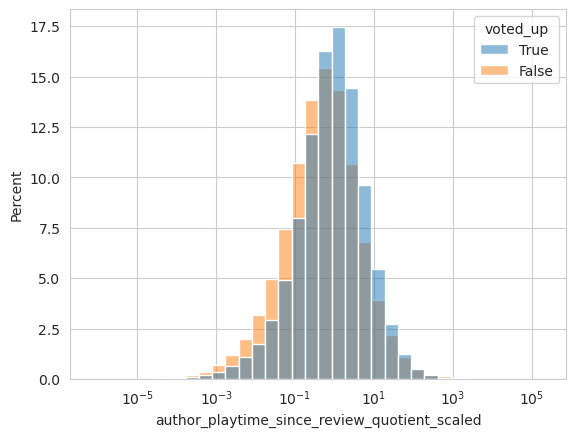

In [15]:
df_reviews["author_playtime_since_review_quotient_scaled"] = (
    df_reviews["author_playtime_forever"] / df_reviews["author_playtime_at_review"]
) - 1


sns.histplot(
    df_reviews,

    x="author_playtime_since_review_quotient_scaled",

    hue="voted_up",
    hue_order=[True, False],

    bins="doane",
    stat="percent",

    common_norm=False,

    log_scale=(True, False),
)

plt.show()

### 3.5 Post-Review Game Abandonment by Sentiment
"Abandonment" is melodramatic; some games you stop playing because you get bored, and some because you're just finished.

Anyway, we can see that the proportion of users who stopped playing post-review is higher for negative revies, but the majority of users stopped playing post-review in both cases.

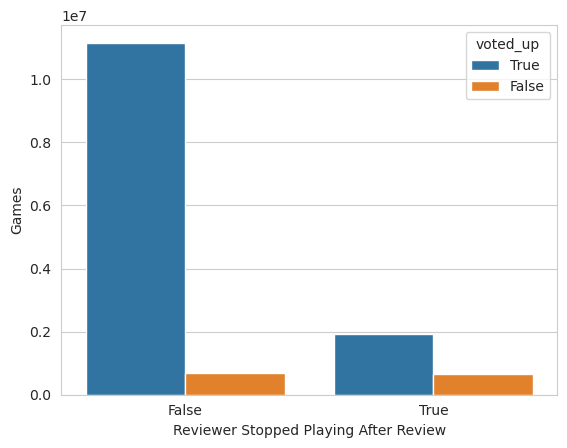

In [16]:
df_reviews["dropped_after_review"] = (
    df_reviews["timestamp_created"] >= df_reviews["author_last_played"]
)


sns.countplot(
    df_reviews,

    x="dropped_after_review",

    hue="voted_up",
    hue_order=[True, False],
)

plt.ylabel("Games")

plt.xlabel("Reviewer Stopped Playing After Review")

plt.show()

## 4. Advanced EDA

### 4.1 Per-Game Playtime by Review Sentiment
The graphs below visualize game playtimes at review for different games, colored by review sentiment. From left to right, the graphs are meant to convey
1. The distribution of playtimes at review
2. A comparison of the distributions of playtimes per-sentiment
3. The proportion of playtimes attributable to a particular sentiment.

We can see that there isn't always a strictly monotonic relationship between playtime and review positivity probability... it may not be possible to try and make sense of these numbers.

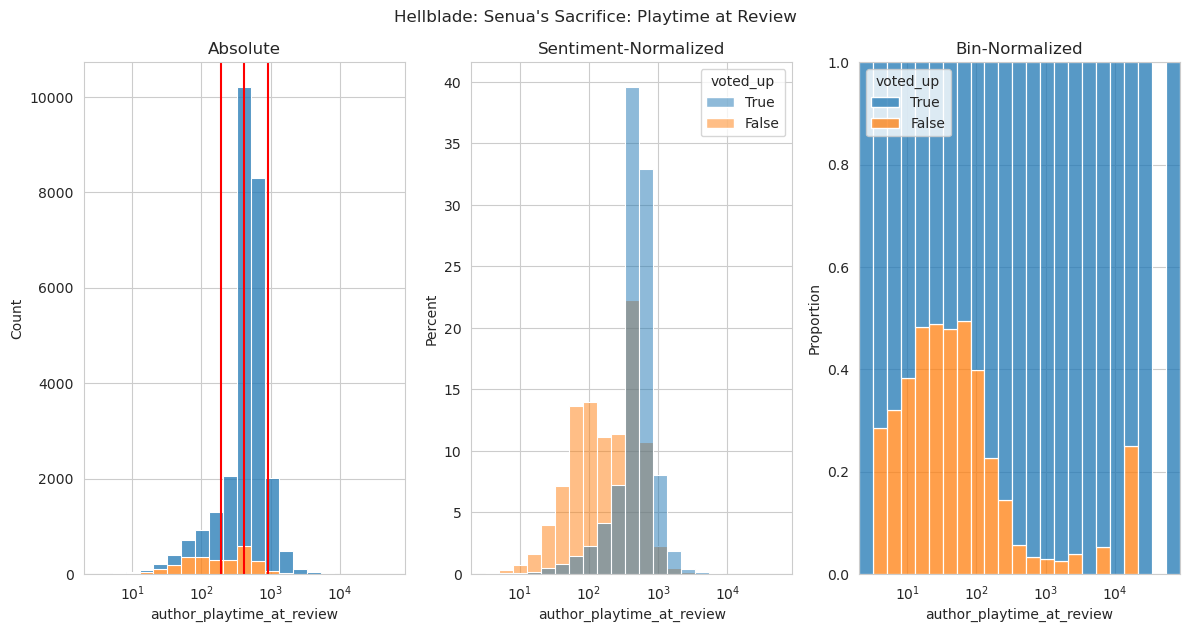

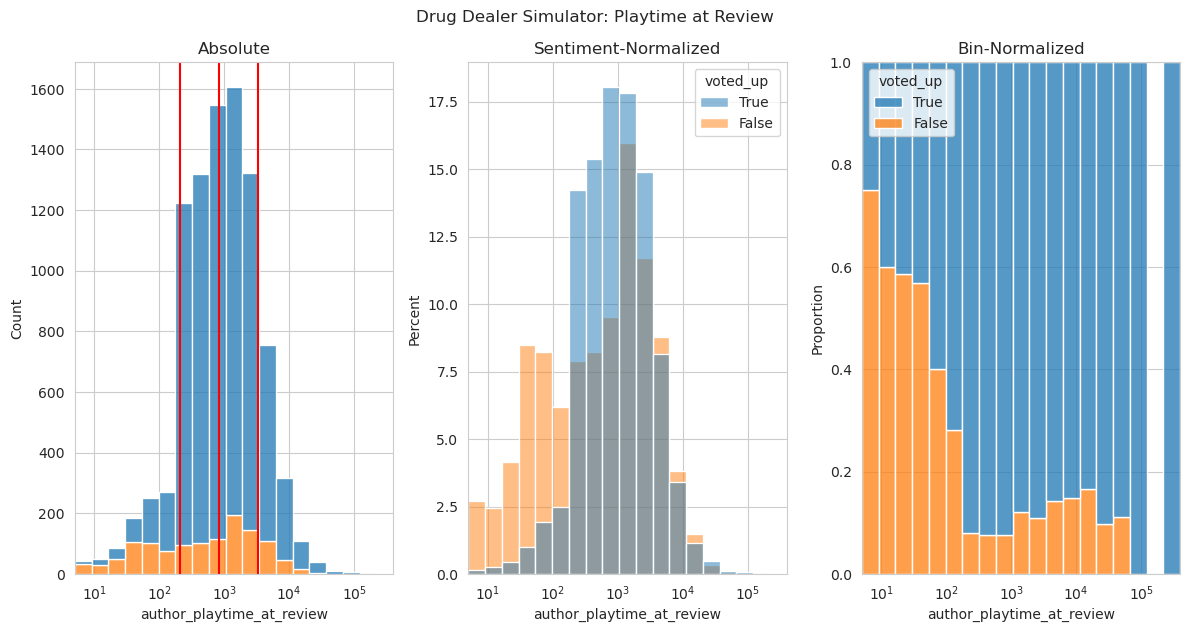

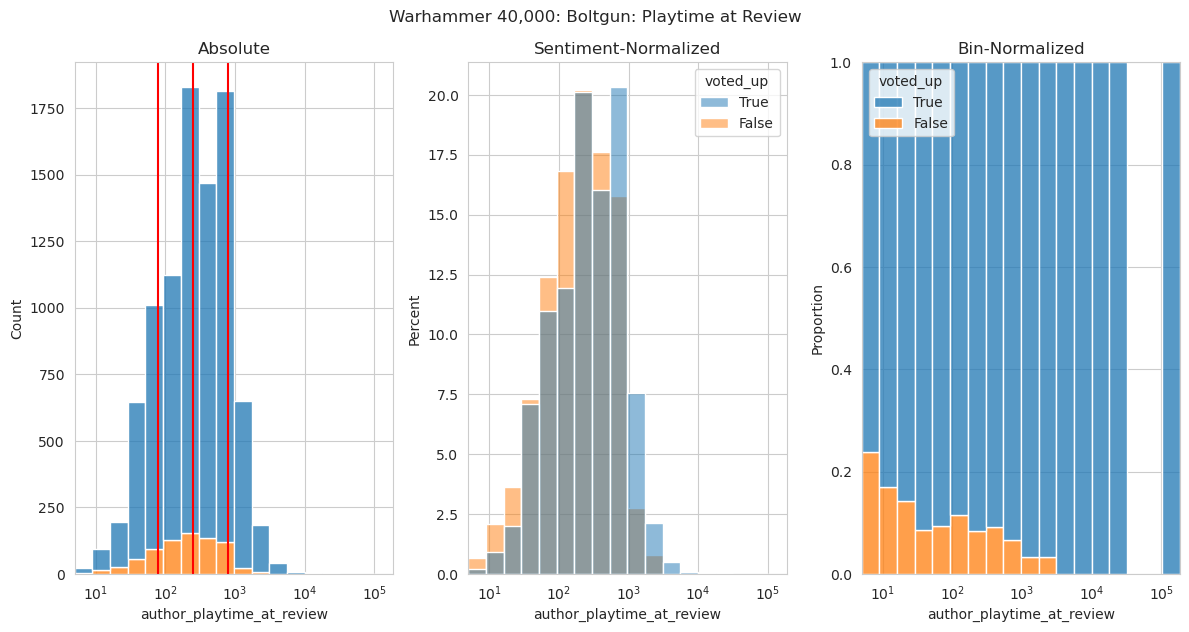

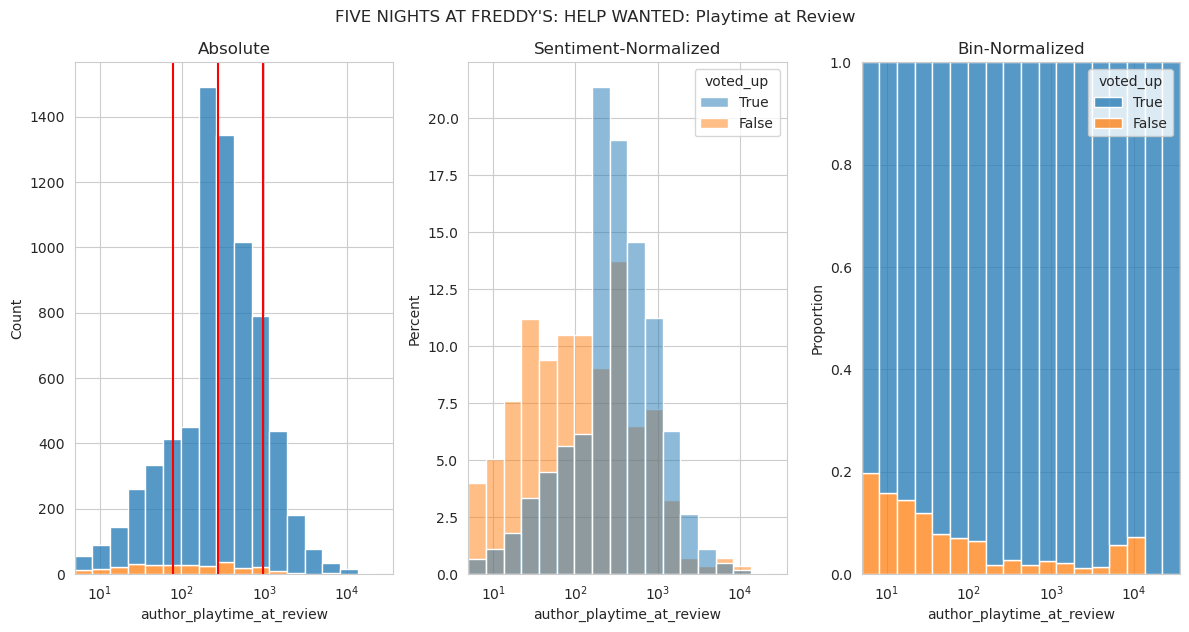

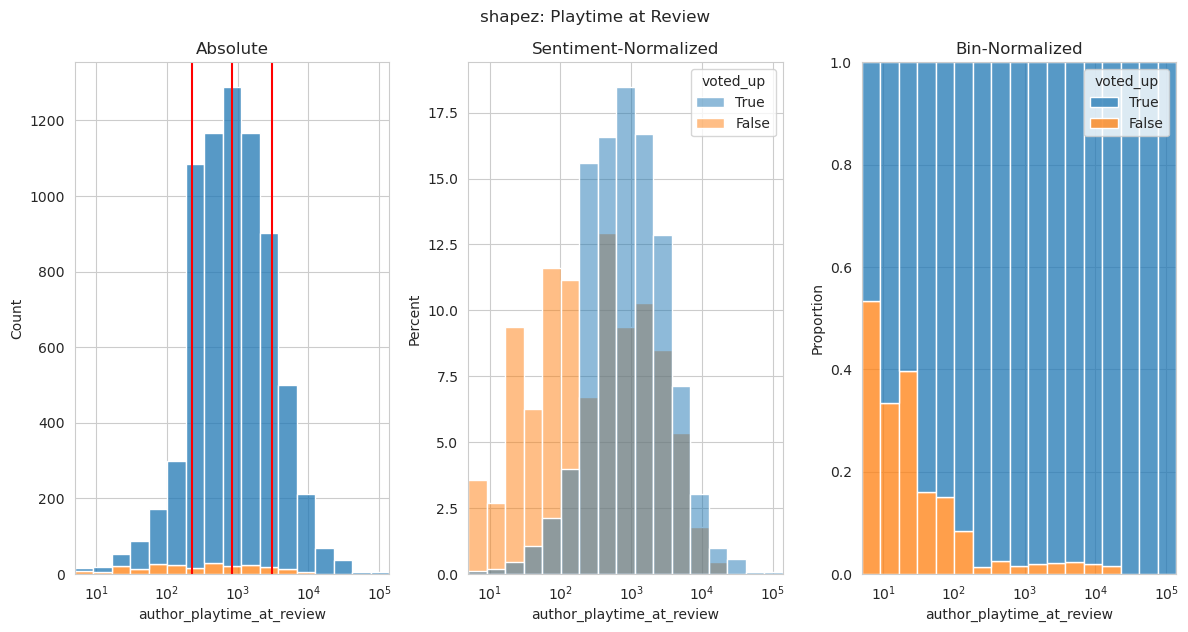

In [ ]:
for appid in (
    df_games[df_games["recommendations"] > 10000].sample(5, random_state=42).index
):
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(4.8*2.5, 6.4), sharex=True)
    sns.histplot(
        df_reviews[df_reviews["steam_appid"] == appid],
        x="author_playtime_at_review",
        hue="voted_up",
        hue_order=[True, False],
        bins="doane",
        multiple="stack",
        log_scale=(True, False),
        ax=ax[0],
    )
    ax[0].axvline(
        10
        ** np.log10(
            df_reviews[df_reviews["steam_appid"] == appid]["author_playtime_at_review"]
        ).mean(),
        c='r'
    )
    ax[0].axvline(
        10
        ** (
            np.log10(
                df_reviews[df_reviews["steam_appid"] == appid][
                    "author_playtime_at_review"
                ]
            ).mean()
            + np.log10(
                df_reviews[df_reviews["steam_appid"] == appid][
                    "author_playtime_at_review"
                ]
            ).std()
        ),
        c='r'
    )
    ax[0].axvline(
        10
        ** (
            np.log10(
                df_reviews[df_reviews["steam_appid"] == appid][
                    "author_playtime_at_review"
                ]
            ).mean()
            - np.log10(
                df_reviews[df_reviews["steam_appid"] == appid][
                    "author_playtime_at_review"
                ]
            ).std()
        ),
        c='r'
    )
    sns.histplot(
        df_reviews[df_reviews["steam_appid"] == appid],
        x="author_playtime_at_review",
        hue="voted_up",
        hue_order=[True, False],
        bins="doane",
        stat="percent",
        common_norm=False,
        log_scale=(True, False),
        ax=ax[1],
    )
    
    sns.histplot(
        df_reviews[df_reviews["steam_appid"] == appid],
        x="author_playtime_at_review",
        hue="voted_up",
        hue_order=[True, False],
        bins="doane",
        stat="proportion",
        common_norm=True,
        multiple='fill',
        log_scale=(True, False),
        ax=ax[2],
    )
        
    ax[0].get_legend().remove()
    ax[0].set_title("Absolute")
    ax[1].set_title("Sentiment-Normalized")
    ax[2].set_title("Bin-Normalized")
    fig.suptitle(f'{df_games.loc[appid, "name"]}: Playtime at Review')
    plt.tight_layout()
    plt.show()

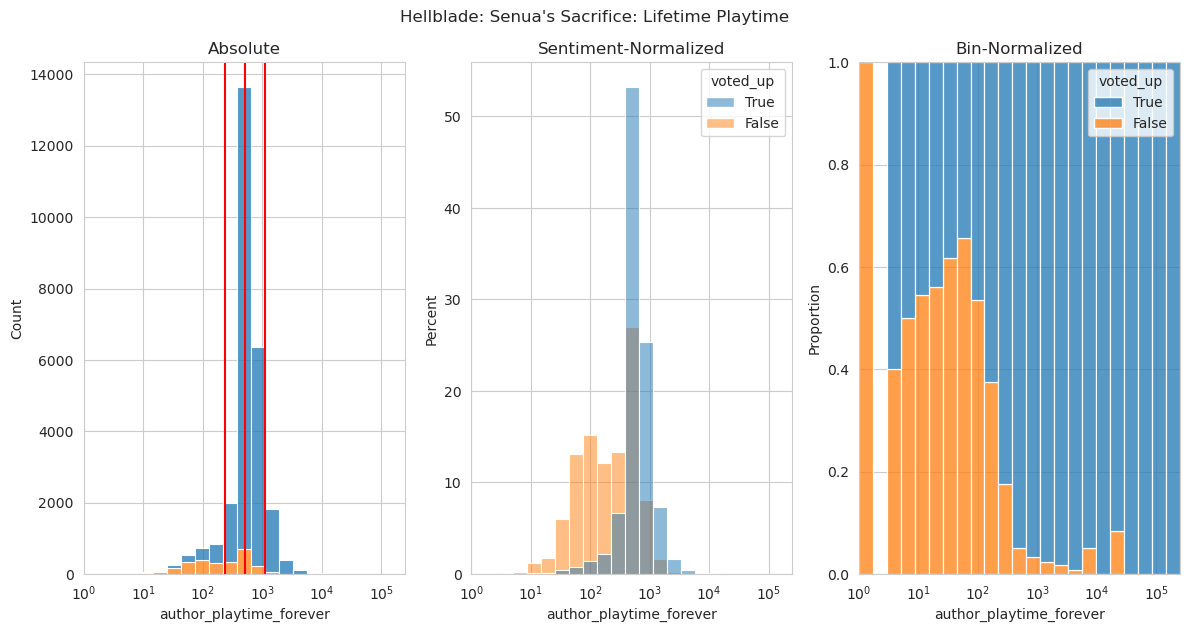

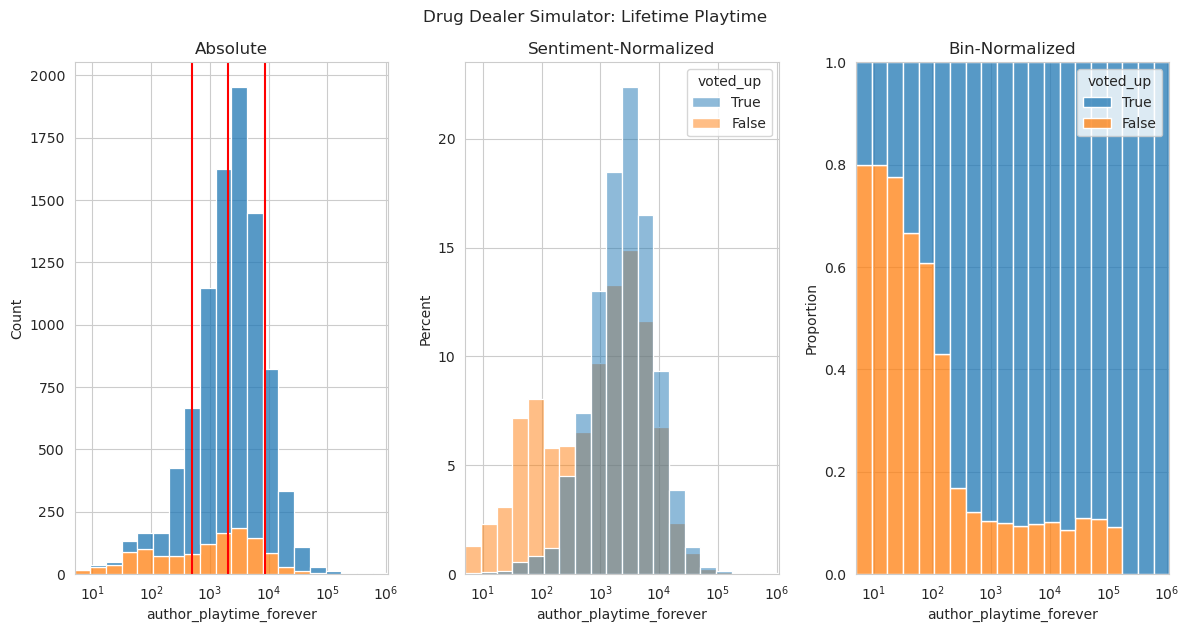

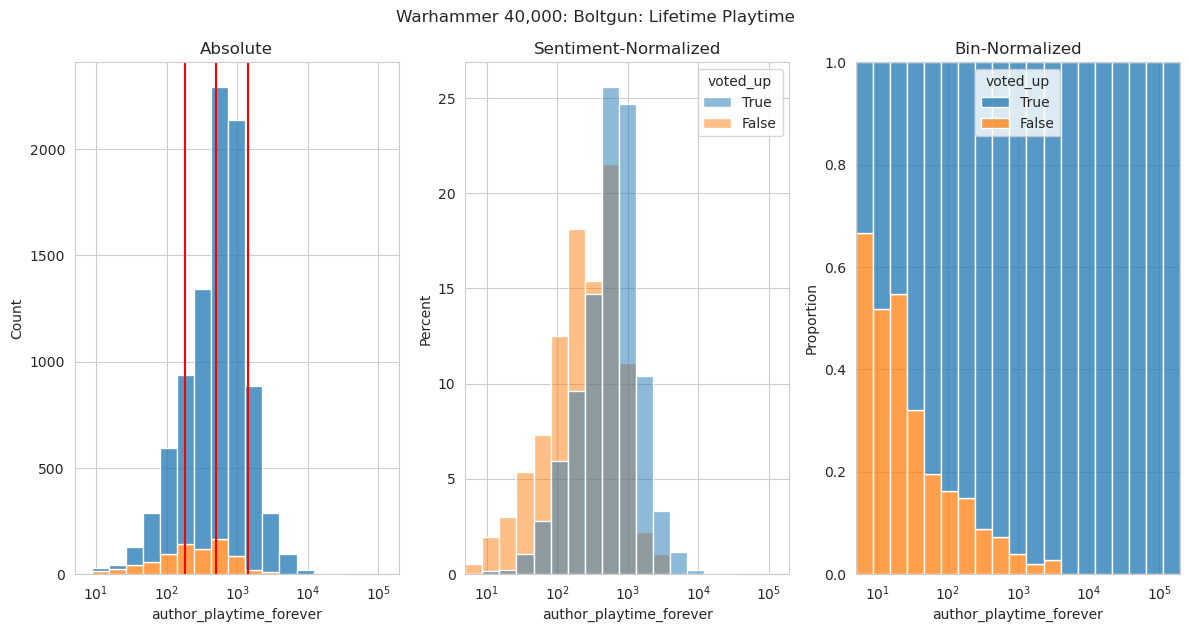

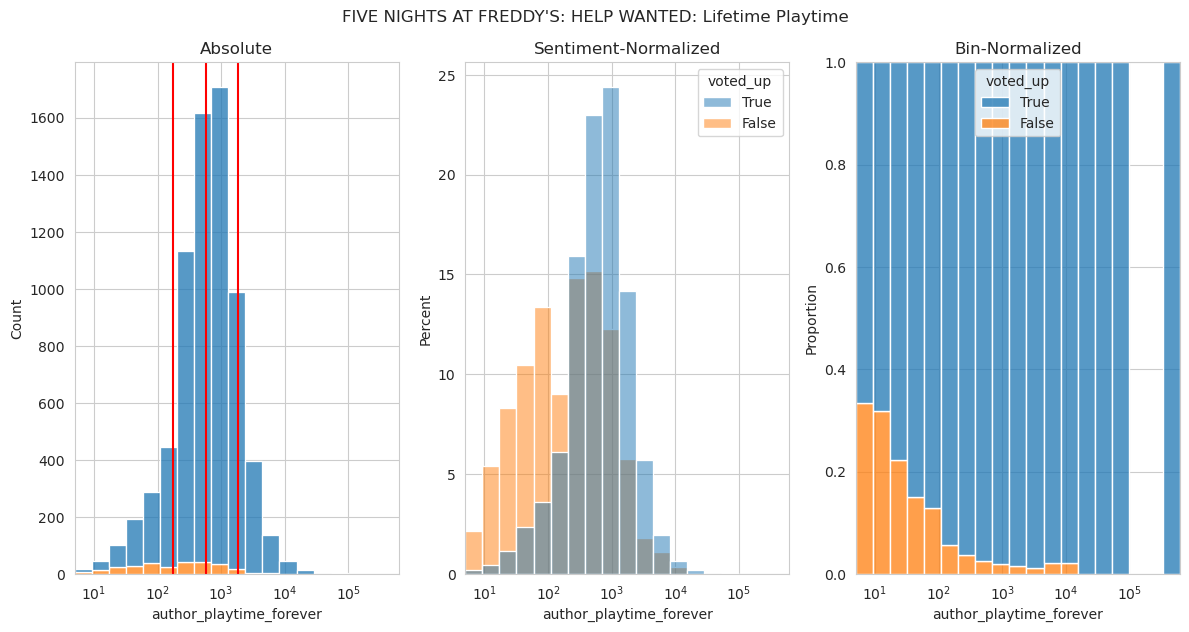

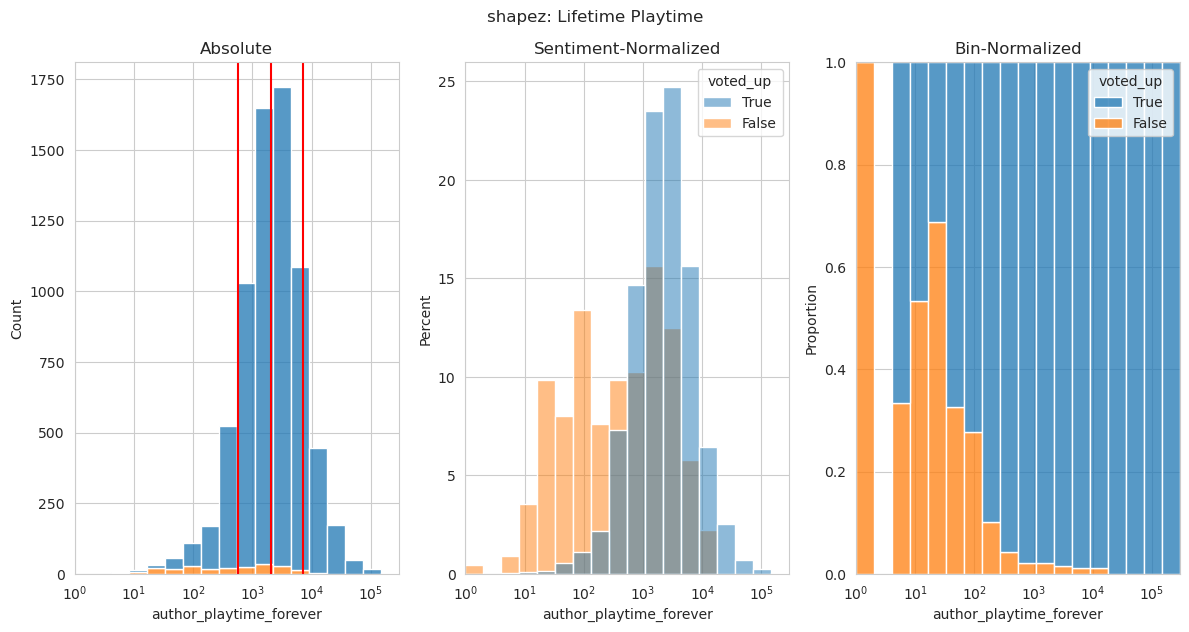

In [43]:
for appid in (
    df_games[df_games["recommendations"] > 10000].sample(5, random_state=42).index
):
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(4.8*2.5, 6.4), sharex=True)
    sns.histplot(
        df_reviews[df_reviews["steam_appid"] == appid],
        x="author_playtime_forever",
        hue="voted_up",
        hue_order=[True, False],
        bins="doane",
        multiple="stack",
        log_scale=(True, False),
        ax=ax[0],
    )
    ax[0].axvline(
        10
        ** np.log10(
            df_reviews[df_reviews["steam_appid"] == appid]["author_playtime_forever"]
        ).mean(),
        c='r'
    )
    ax[0].axvline(
        10
        ** (
            np.log10(
                df_reviews[df_reviews["steam_appid"] == appid][
                    "author_playtime_forever"
                ]
            ).mean()
            + np.log10(
                df_reviews[df_reviews["steam_appid"] == appid][
                    "author_playtime_forever"
                ]
            ).std()
        ),
        c='r'
    )
    ax[0].axvline(
        10
        ** (
            np.log10(
                df_reviews[df_reviews["steam_appid"] == appid][
                    "author_playtime_forever"
                ]
            ).mean()
            - np.log10(
                df_reviews[df_reviews["steam_appid"] == appid][
                    "author_playtime_forever"
                ]
            ).std()
        ),
        c='r'
    )
    sns.histplot(
        df_reviews[df_reviews["steam_appid"] == appid],
        x="author_playtime_forever",
        hue="voted_up",
        hue_order=[True, False],
        bins="doane",
        stat="percent",
        common_norm=False,
        log_scale=(True, False),
        ax=ax[1],
    )
    
    sns.histplot(
        df_reviews[df_reviews["steam_appid"] == appid],
        x="author_playtime_forever",
        hue="voted_up",
        hue_order=[True, False],
        bins="doane",
        stat="proportion",
        common_norm=True,
        multiple='fill',
        log_scale=(True, False),
        ax=ax[2],
    )
        
    ax[0].get_legend().remove()
    ax[0].set_title("Absolute")
    ax[1].set_title("Sentiment-Normalized")
    ax[2].set_title("Bin-Normalized")
    fig.suptitle(f'{df_games.loc[appid, "name"]}: Lifetime Playtime')
    plt.tight_layout()
    plt.show()